1. Importing Libraries & Dataset
2. (Optional) Apply Gaussian smoothing. Helps eliminate inconsistency to noise. Sigma strength may implicate results.
3. Apply operators(Sobel-Feldman, Robert's Cross, & Laplacian). Extract necessary patch from original image, and multiply against operator before summing results. Store scalar as new pixel in output image.
5. Adjust output image as necessary.
6. (Optional) Thresholding.
7. Display & Save results.

# 1. Importing

In [2]:
import os
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

import pandas as pd
import tensorflow as tf
import keras as ks

320


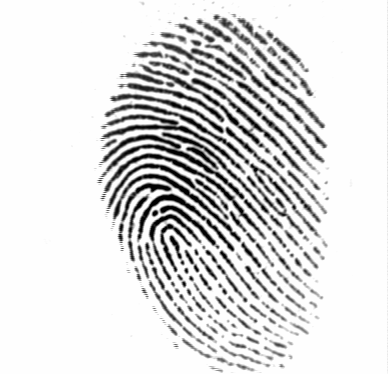

In [3]:
images_list = list()
directory = 'C:\\Users\\lukas\\OneDrive\\Desktop\\Programming\\PycharmProjects\\EdgeDetectionPaper\\images\\fingerprints'

directory2 = 'C:\\Users\\lukas\\OneDrive\\Desktop\\Programming\\PycharmProjects\\EdgeDetectionPaper\\images\\Leaves'

for folder in os.listdir(directory):
    sub_folder = os.path.join(directory, folder)
    for img in os.listdir(sub_folder):
        img = os.path.join(sub_folder, img)

        if os.path.isfile(img):
            images_list.append(PIL.Image.open(img).convert('L'))


print(len(images_list))
images_list[0]

# Settings

In [4]:
# Display tonemap
color_map = 'gray'

# Blur strength. Default 0.5,1,1.5
gauss_sigma = np.arange(0,6)*0.5

# Threshold percent 0-100
lap_threshold = 100 # 50-100% is good
SF_threshold = 100
RC_threshold = 100

# 2. Gaussian Smoothing

In [5]:
blurred_images = dict()

for sigma in gauss_sigma:
    blurred_images['str:',sigma] = list()
    blurred_images['str:',sigma].append(gaussian_filter(images_list[0], sigma=sigma))

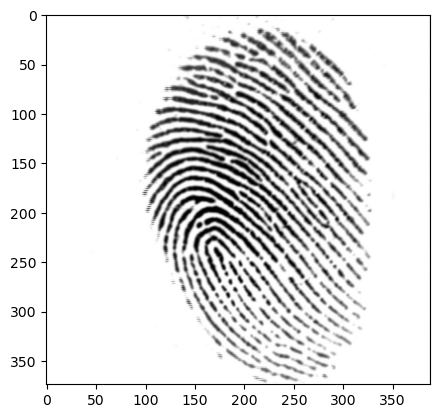

In [6]:
plt.imshow(blurred_images['str:', .5][0], cmap=color_map)
plt.show()

# (Optional) Padding

(374, 388)
(376, 390)


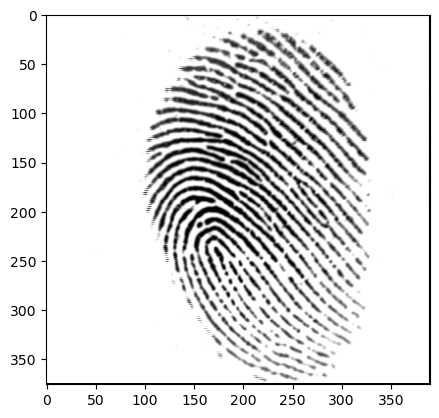

In [7]:
padded_blurred_images = dict()
padded_images = list()

for blur_str in blurred_images:
    padded_blurred_images[blur_str] = list()
    for img in blurred_images[blur_str]:
        padded_blurred_images[blur_str].append(np.pad(img, [(1,1)], mode='constant'))

for img in images_list:
    padded_images.append(np.pad(img, [(1,1)], mode='constant'))

print(blurred_images['str:',0][0].shape)
print(padded_blurred_images['str:',0][0].shape)
plt.imshow(padded_blurred_images['str:',0][0], cmap=color_map)
plt.show()

# 3. Operators
### Generalized operator

In [8]:
def operator(images):
    o_images = list()
    completed = 0
    kernel = np.array([[0, 1, 0],
                       [1, -4, 1],
                       [0, 1, 0]])

    for image in images:
        output_image = np.zeros_like(image)
        for x in range(1, image.shape[0]-2):
            for y in range(1, image.shape[1]-2):
                patches = image[x-1:x+2, y-1:y+2]
                result = np.sum(patches*kernel)
                output_image[x][y] = result

        o_images.append(output_image)
        completed+=1
        print(str(completed) + "/" + str(len(images)), end="\r")
    return o_images

def roberts_operator(images, kernel):
    output_images = list()
    completed = 0

    for image in images:
        output_image = np.zeros_like(image)
        for x in range(1, image.shape[0]-2):
            for y in range(1, image.shape[1]-2):
                patch = np.array([[image[x,y-1], image[x-1,y]],
                         [image[x,y+1], image[x+1,y]]])

                result = np.sum(patch*kernel)
                output_image[x][y] = result

        output_images.append(output_image)
        completed+=1
        print(str(completed) + "/" + str(len(images)), end="\r")
        if completed >= 1:
            break
    return output_images


### Laplacian

In [9]:

laplacian_images = dict()
for blur_str in padded_blurred_images:
    laplacian_images[blur_str] = operator(padded_blurred_images[blur_str])

### Sobel-Feldman

In [10]:
SF_horizontal_kernel = np.array([[-1, 0, 1],
                                 [-2, 0, 2],
                                 [-1, 0, 1]])
SF_vertical_kernel = np.array([[-1,-2,-1],
                               [ 0, 0, 0],
                               [ 1, 2, 1]])
SF_horizontal_output = dict()
SF_vertical_output = dict()
for blur_str in padded_blurred_images:
    SF_horizontal_output[blur_str] = operator(padded_blurred_images[blur_str], SF_horizontal_kernel)
    SF_vertical_output[blur_str] = operator(padded_blurred_images[blur_str], SF_vertical_kernel)

### Robert's Cross

In [11]:
RC_horizontal_kernel = np.array([[+1,0],
                                [0,-1]])
RC_vertical_kernel = np.array([[0,+1],
                              [-1,0]])
RC_horizontal_output = dict()
RC_vertical_output = dict()

for blur_str in padded_blurred_images:
    RC_horizontal_output[blur_str] = roberts_operator(padded_blurred_images[blur_str], RC_horizontal_kernel)
    RC_vertical_output[blur_str] = roberts_operator(padded_blurred_images[blur_str], RC_vertical_kernel)

### Gradient computation

##### Laplacian
Needs no gradient computation, since the algorithm only uses one Kernel.

##### Sobel-Feldman

In [12]:
SF_images = dict()

for blur_str in SF_horizontal_output:
    SF_images[blur_str] = list()
    for i in range(len(SF_horizontal_output[blur_str])):
        SF_images[blur_str].append(SF_horizontal_output[blur_str][i]^2 + SF_vertical_output[blur_str][i]^2)

##### Robert's Cross

In [13]:
RC_images = dict()

for blur_str in RC_horizontal_output:
    RC_images[blur_str] = list()
    for i in range(len(RC_horizontal_output[blur_str])):
        RC_images[blur_str].append(RC_horizontal_output[blur_str][i]^2 + RC_vertical_output[blur_str][i]^2)

### Thresholding

Adding extra images for testing purposes

In [14]:
for blur_str in laplacian_images:
    for i in range(9):
        laplacian_images[blur_str].append(laplacian_images[blur_str][0])
        RC_images[blur_str].append(RC_images[blur_str][0])
        SF_images[blur_str].append(SF_images[blur_str][0])

In [15]:
def apply_threshold(images, threshold, dynamic_threshold):
    output = list()
    threshold_step = threshold / len(images)-1
    for img in images:
        if dynamic_threshold:
            print(np.max(img)*threshold/100, threshold, end=", ")
            threshold -= threshold_step

        output.append(np.where(img >= threshold, np.max(img), 0))
    return output

In [16]:
laplacian_th_images = dict()
SF_th_images = dict()
RC_th_images = dict()

for blur_str in laplacian_images:
    laplacian_th_images[blur_str] = apply_threshold(laplacian_images[blur_str], lap_threshold, True)
    print("")

for blur_str in SF_images:
    SF_th_images[blur_str] = apply_threshold(SF_images[blur_str], SF_threshold, True)
    print("")

for blur_str in RC_images:
    RC_th_images[blur_str] = apply_threshold(RC_images[blur_str], RC_threshold, True)
    print("")


255.0 100, 232.05 91.0, 209.1 82.0, 186.15 73.0, 163.2 64.0, 140.25 55.0, 117.3 46.0, 94.35 37.0, 71.4 28.0, 48.45 19.0, 
255.0 100, 232.05 91.0, 209.1 82.0, 186.15 73.0, 163.2 64.0, 140.25 55.0, 117.3 46.0, 94.35 37.0, 71.4 28.0, 48.45 19.0, 
255.0 100, 232.05 91.0, 209.1 82.0, 186.15 73.0, 163.2 64.0, 140.25 55.0, 117.3 46.0, 94.35 37.0, 71.4 28.0, 48.45 19.0, 
255.0 100, 232.05 91.0, 209.1 82.0, 186.15 73.0, 163.2 64.0, 140.25 55.0, 117.3 46.0, 94.35 37.0, 71.4 28.0, 48.45 19.0, 
255.0 100, 232.05 91.0, 209.1 82.0, 186.15 73.0, 163.2 64.0, 140.25 55.0, 117.3 46.0, 94.35 37.0, 71.4 28.0, 48.45 19.0, 
255.0 100, 232.05 91.0, 209.1 82.0, 186.15 73.0, 163.2 64.0, 140.25 55.0, 117.3 46.0, 94.35 37.0, 71.4 28.0, 48.45 19.0, 
254.0 100, 231.14 91.0, 208.28 82.0, 185.42 73.0, 162.56 64.0, 139.7 55.0, 116.84 46.0, 93.98 37.0, 71.12 28.0, 48.26 19.0, 
254.0 100, 231.14 91.0, 208.28 82.0, 185.42 73.0, 162.56 64.0, 139.7 55.0, 116.84 46.0, 93.98 37.0, 71.12 28.0, 48.26 19.0, 
254.0 100, 231.14 

### Display

In [17]:
def display_images(image_dict):
    cols, rows = len(next(iter(image_dict.values()))), len(image_dict.keys())
    fig = plt.figure(figsize=(cols*2.5,2.5*rows*1.05))

    print(len(next(iter(image_dict.values()))), len(image_dict.keys()))
    i = 1
    for key in image_dict:
        for img in image_dict[key]:
            fig.add_subplot(rows,cols, i)
            plt.imshow(img, cmap=color_map)
            i += 1

    # The below does not do any logic,
    # it is simply labelling the rows/cols for easier understanding.
    # There is no need to try to understand this stuff. It looks pretty bad...
    for e, ax in enumerate(fig.get_axes()):
        ax.set_axis_off()
        if e == e % cols:
            ax.annotate(str(int((100/cols)*e))+"%",
                xy=(0.5, 1),
                xytext=(0, 2.5),
                xycoords="axes fraction",
                textcoords="offset points",
                ha="center",
                va="baseline")
        if e%cols==0:
            h = "gauss:" + str(list(image_dict.keys())[int(e/cols)][1:])
            ax.annotate(h,
                xy=(0, 0),
                xytext=(0, 0),
                textcoords="offset points",
                ha="right",
                va="top",
                rotation= 90
            )
    plt.tight_layout()
    plt.show()

10 6


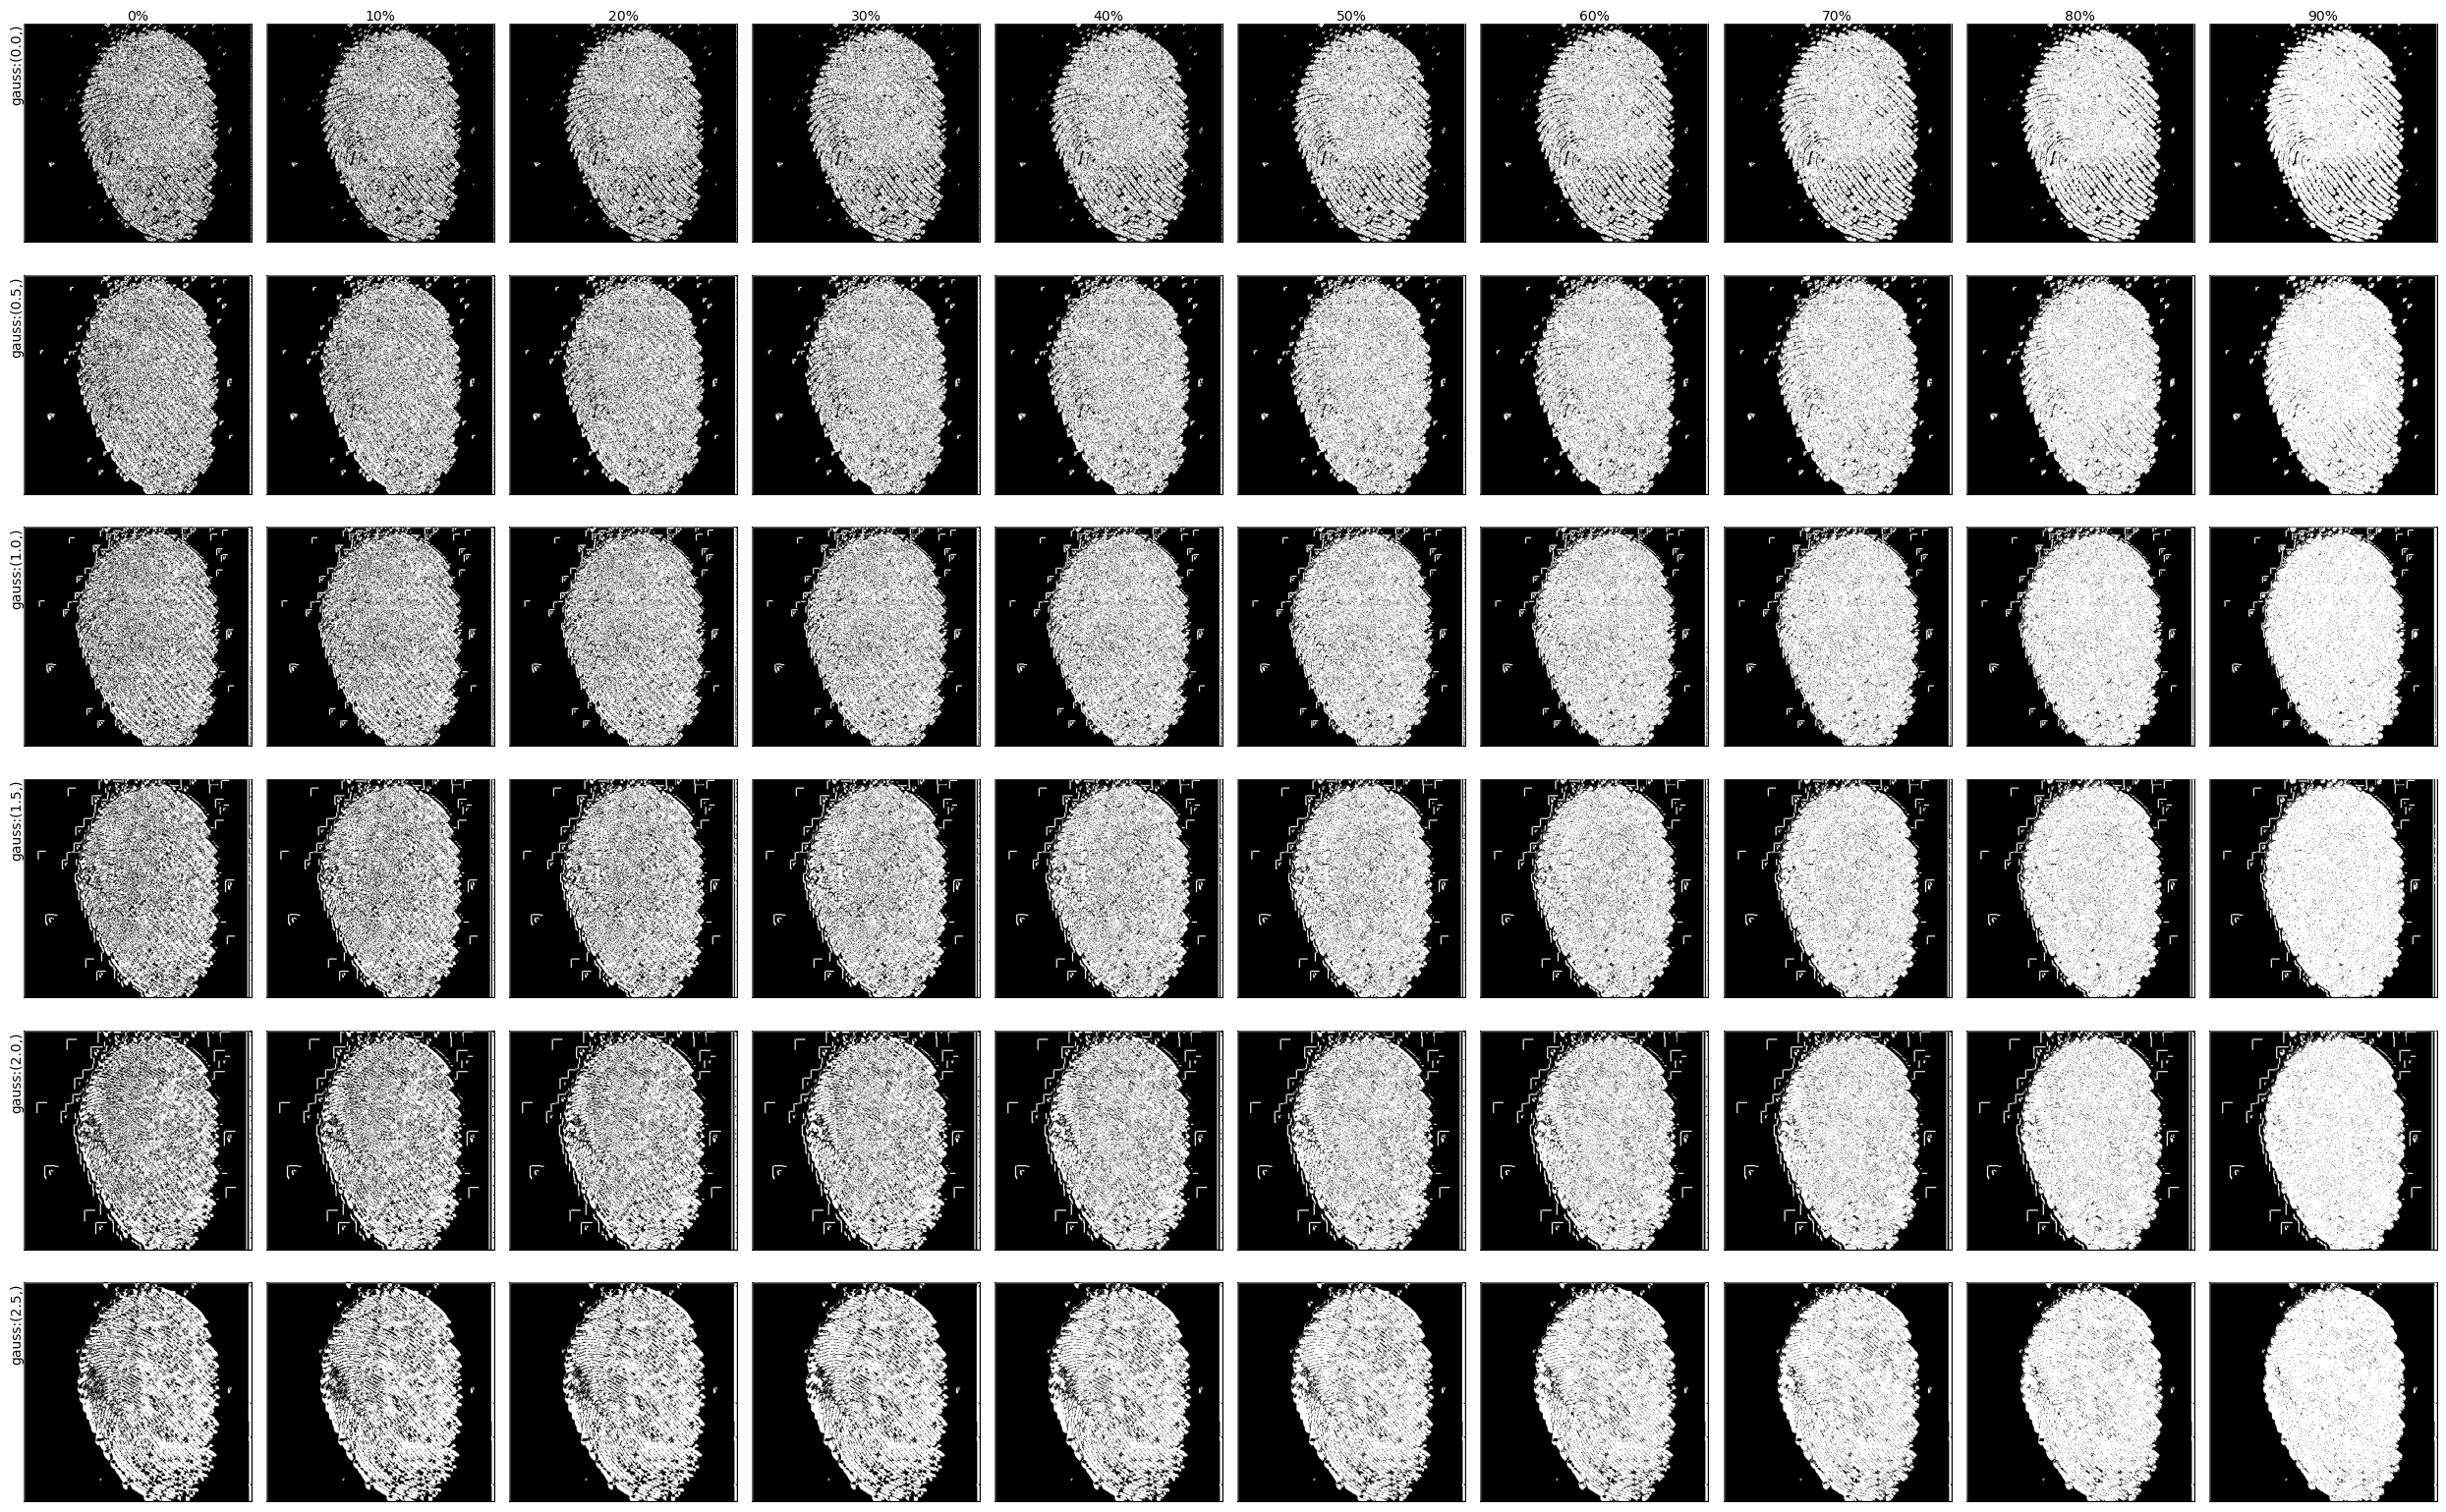

In [28]:
display_images(SF_th_images)
# display_images(SF_th_images)
# display_images(RC_th_images)

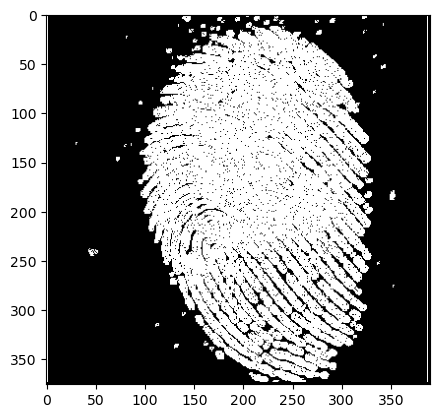

In [31]:
plt.imshow(SF_th_images['str:',0][9], cmap=color_map)
plt.show()